# Python-Data-2A-ENSAE

We present here the main results of our work.

## Data analysis

First, we analyse our data, starting with our MNIST data.

c:\Users\yanno\OneDrive\Documents\GitHub\Python-Data-2A-ENSAE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Chargement des données originales...


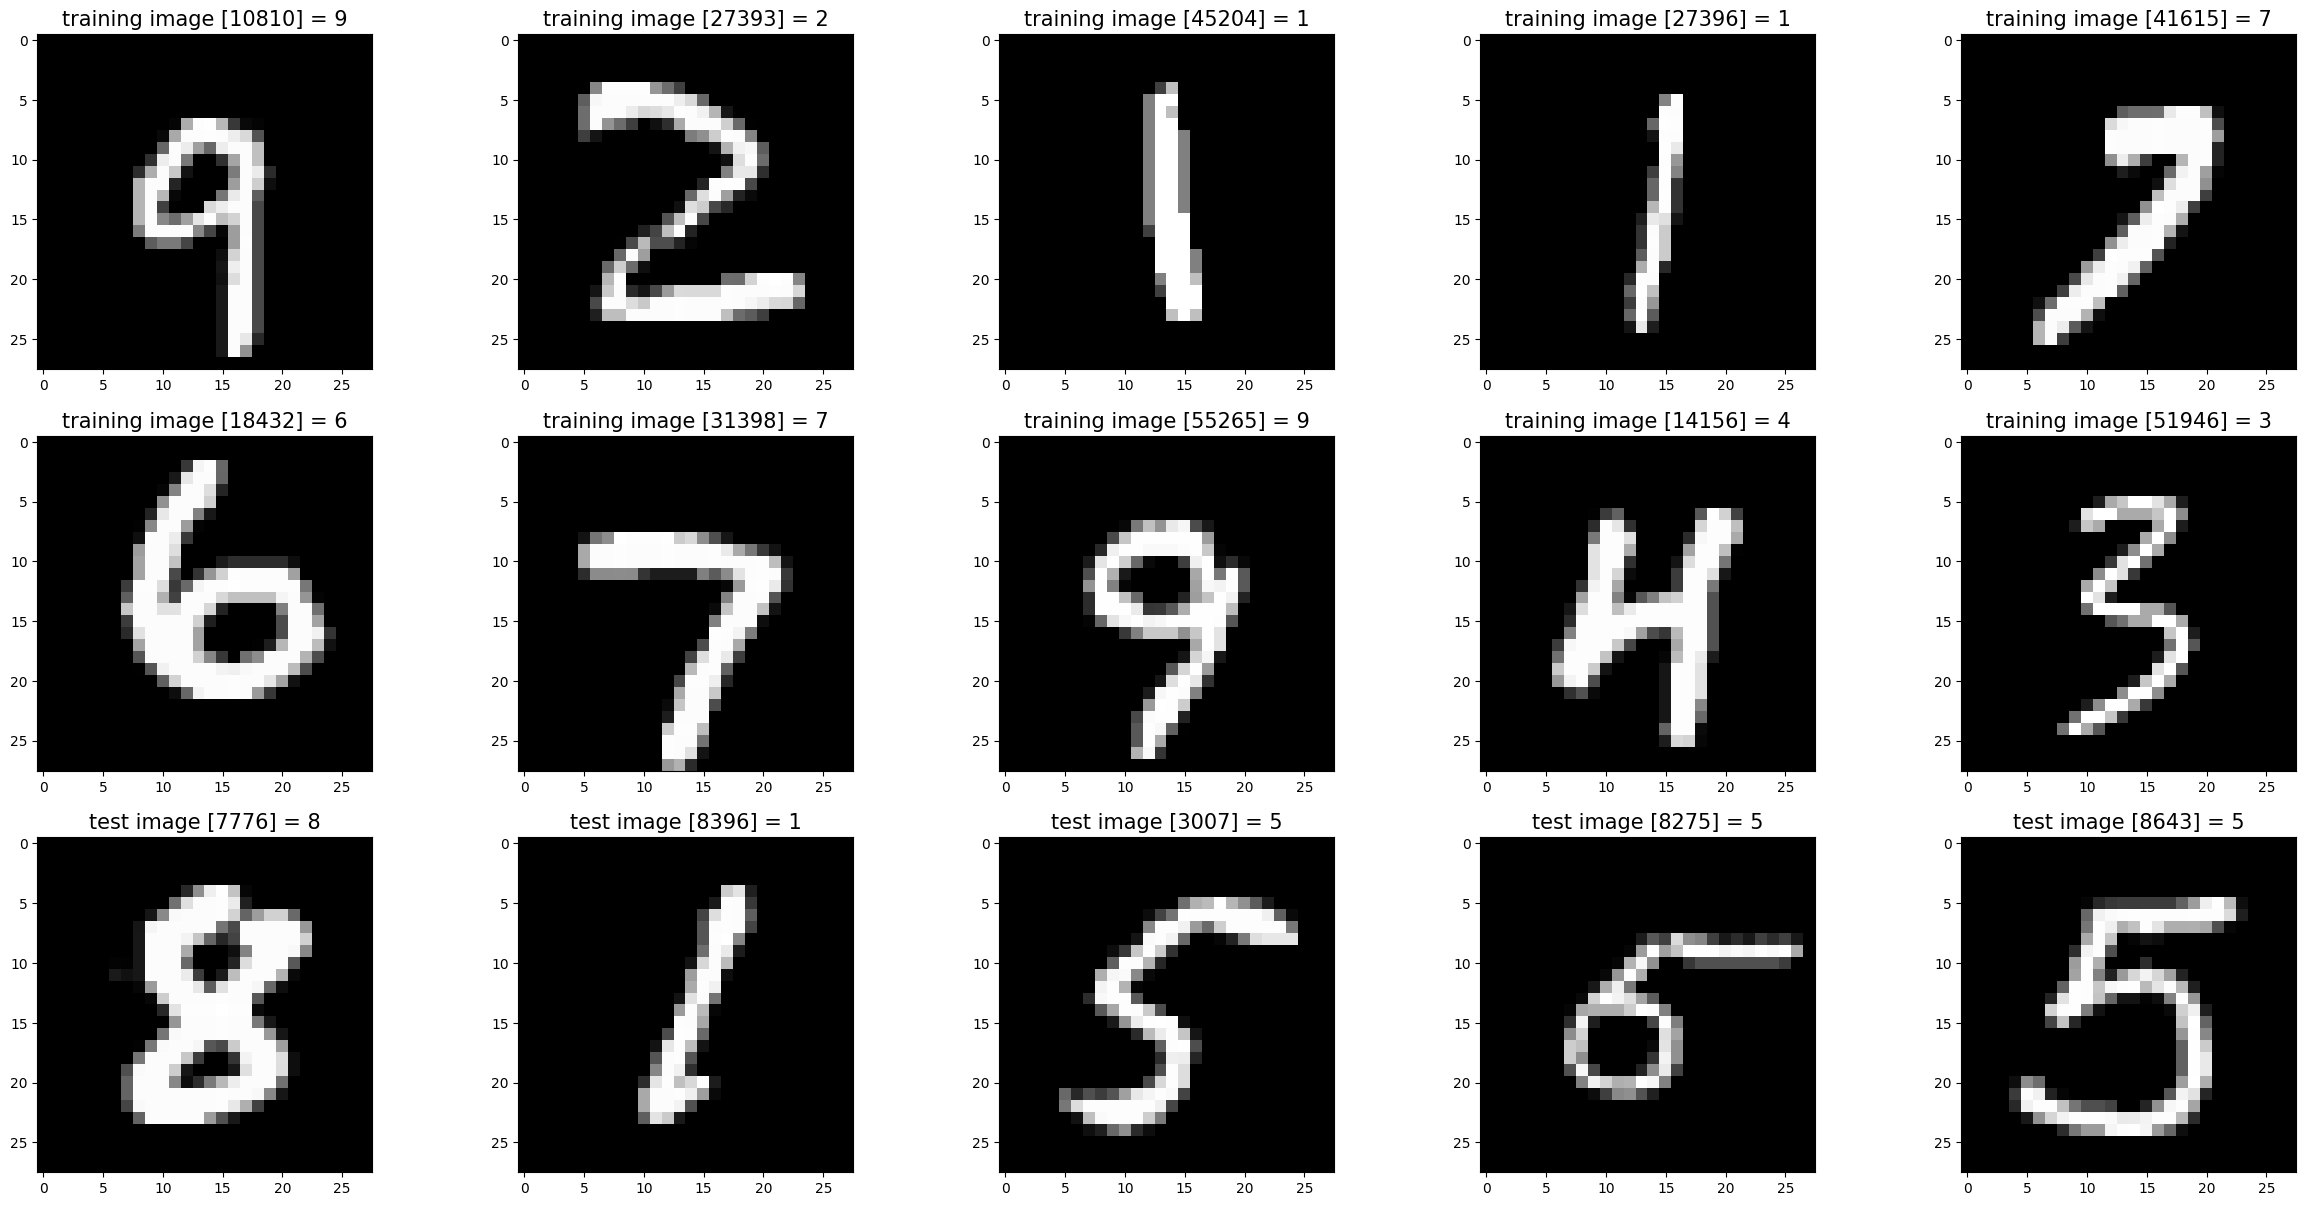

In [1]:
from MNIST import MnistDataloader, show_images

mnist = MnistDataloader(data_dir="..\\data\\MNIST")
show_images(show_noisy=False, rseed=21)

Chargement des données avec bruit (gaussian, facteur: 0.1)...


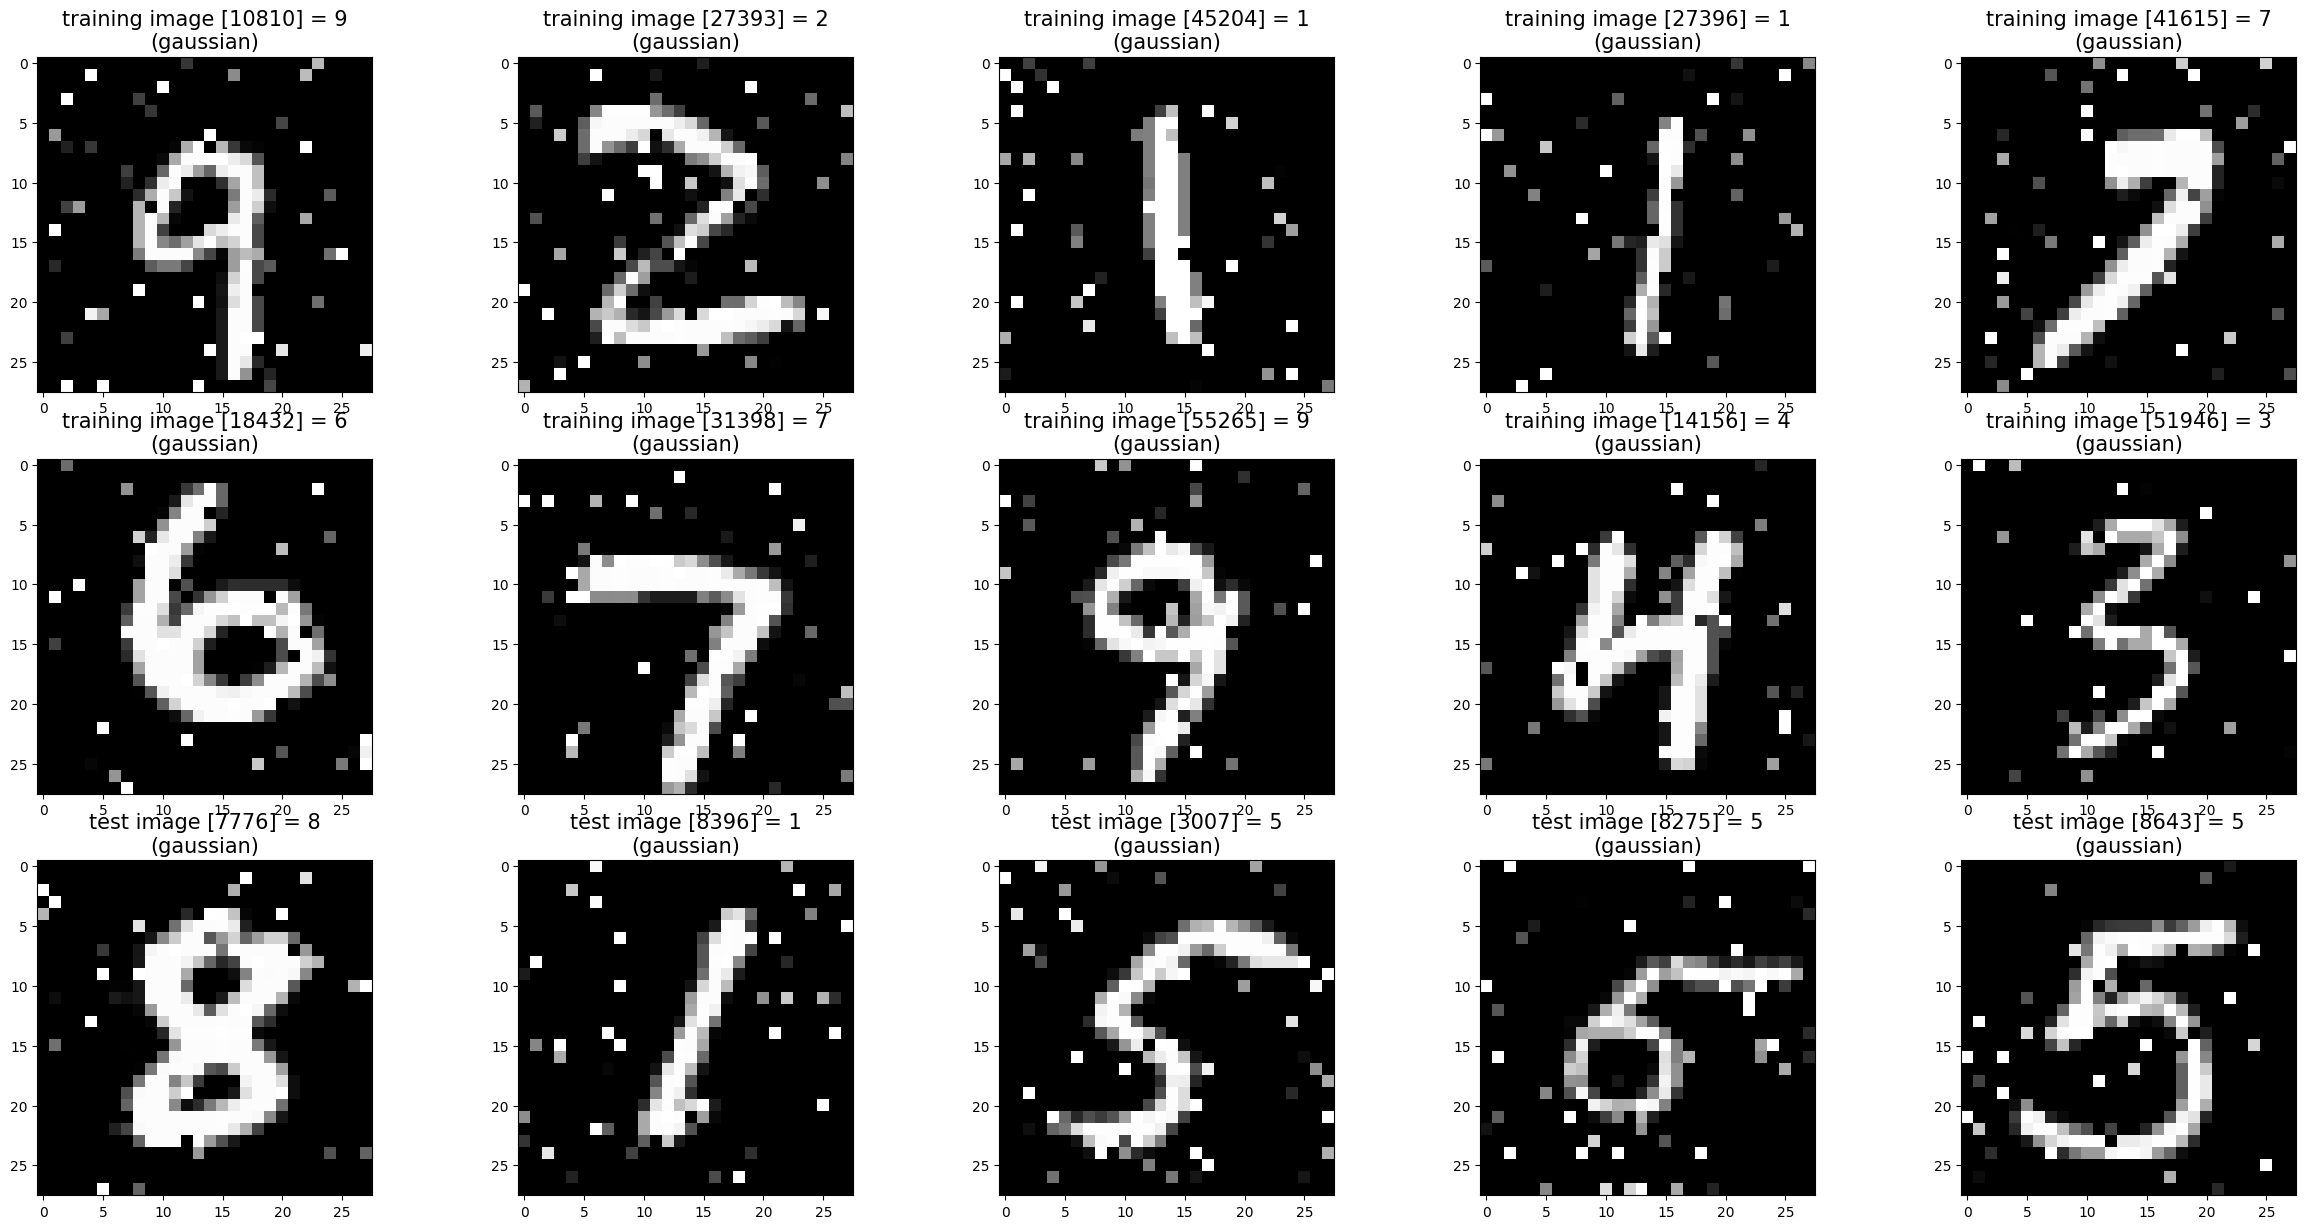

In [2]:
show_images(show_noisy=True, noise_type="gaussian", noise_factor=0.1, rseed=21)

Chargement des données avec bruit (salt_and_pepper, facteur: 0.1)...


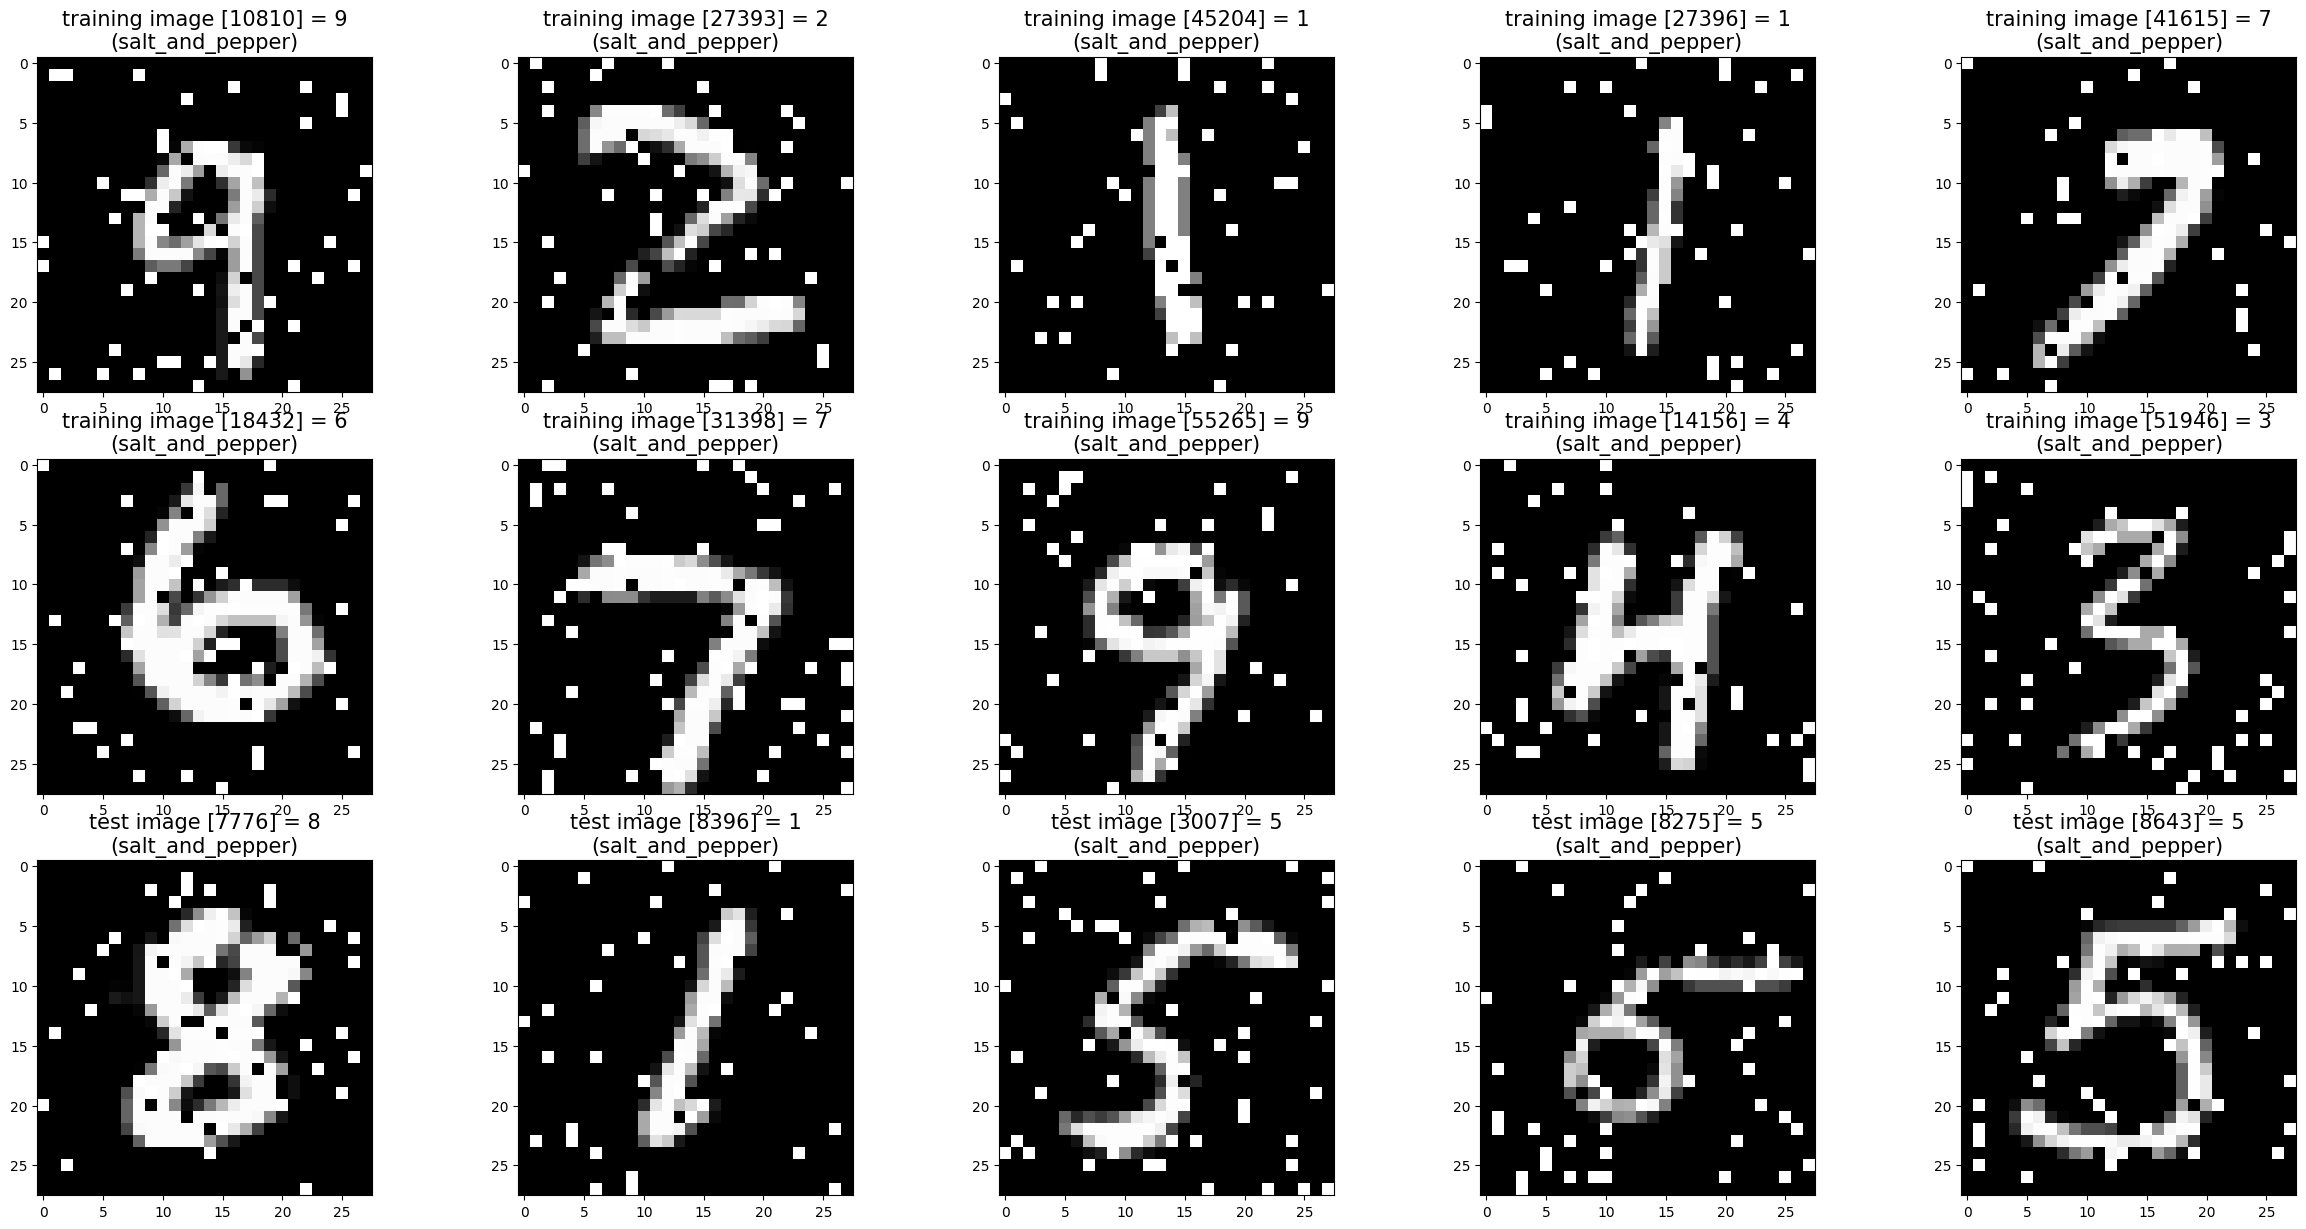

In [16]:
show_images(show_noisy=True, noise_type="salt_and_pepper", noise_factor=0.1, rseed=21)

On va réduire la dimension des données avec une analyse en composante principale et a